In [1]:
import warnings
warnings.filterwarnings('ignore')

# https://www.kaggle.com/datasets/kmader/finding-lungs-in-ct-data

In [2]:
# pip install scikit-image

In [3]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize

import os, glob


import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [4]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [5]:
img_list = sorted(glob.glob('2d_images/*.tif'))
mask_list = sorted(glob.glob('2d_masks/*.tif'))

print(len(img_list), len(mask_list))

267 267


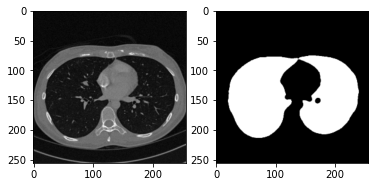

In [6]:
IMG_SIZE = 256

x_data, y_data = np.empty((2, len(img_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

for i, img_path in enumerate(img_list):
    img = imread(img_path)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    x_data[i] = img
    
for i, img_path in enumerate(mask_list):
    img = imread(img_path)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    y_data[i] = img
    
y_data /= 255.

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[12].squeeze(), cmap='gray')
ax[1].imshow(y_data[12].squeeze(), cmap='gray')

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(240, 256, 256, 1) (240, 256, 256, 1)
(27, 256, 256, 1) (27, 256, 256, 1)


In [8]:
inputs = Input(shape=(256, 256, 1))

net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0     

In [10]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=16)

Train on 240 samples, validate on 27 samples
Epoch 1/20
240/240 [==============================] - 15s 64ms/sample - loss: 0.5346 - acc: 0.7435 - mse: 0.1734 - val_loss: 0.4434 - val_acc: 0.7541 - val_mse: 0.1448
Epoch 2/20
240/240 [==============================] - 32s 133ms/sample - loss: 0.4314 - acc: 0.7411 - mse: 0.1424 - val_loss: 0.3932 - val_acc: 0.7541 - val_mse: 0.1301
Epoch 3/20
240/240 [==============================] - 11s 45ms/sample - loss: 0.4018 - acc: 0.7510 - mse: 0.1343 - val_loss: 0.4141 - val_acc: 0.7320 - val_mse: 0.1379
Epoch 4/20
240/240 [==============================] - 21s 89ms/sample - loss: 0.3706 - acc: 0.7677 - mse: 0.1242 - val_loss: 0.2927 - val_acc: 0.8309 - val_mse: 0.0947
Epoch 5/20
240/240 [==============================] - 11s 47ms/sample - loss: 0.3038 - acc: 0.8277 - mse: 0.0978 - val_loss: 0.3103 - val_acc: 0.8131 - val_mse: 0.1012
Epoch 6/20
240/240 [==============================] - 11s 45ms/sample - loss: 0.2855 - acc: 0.8412 - mse: 0.0912 -

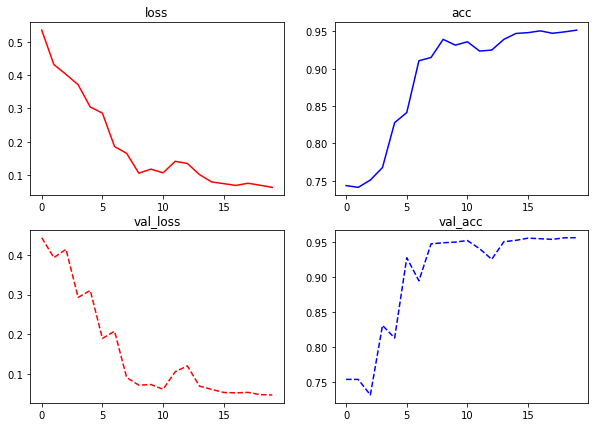

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['acc'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_acc'], 'b--')

In [ ]:
preds = model.predict(x_val)

fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')